# Notebook Intentions

The purpose of this notebook is to simulate an amusement park. 


In [39]:
from park import Park
from behavior_reference import BEHAVIOR_ARCHETYPE_PARAMETERS

### Book Keeping

    - Version: dictates the location performance graphs are stored
    - Verbosity: controls much information is displayed during a simulation, increase to show more info
    - Show Plots: controls whether park plots are displayed in this notebook
    - RNG Seed: seeds random number generators to enforce identical results across runs/machines
    

In [40]:
VERSION = "20K All FP - MIKE"
VERBOSITY = 0
SHOW_PLOTS = True
RNG_SEED = 5


## Park
 
The park contains Agents, Attractions and Activities.

- Total Daily Agents: dictates how many agents visit the park within a day
- Hourly Percent: dictates what percentage of Total Daily Agents visits the park at each hour
- Perfect Arrivals: enforces that the exact amount of Total Daily Agents arrives during the day
- Expedited Pass Ability Percent: percent of agents aware of expeditied passes
- Expedited Threshold: acceptable queue wait time length before searching for an expedited pass
- Expedited Limit: total number of expedited pass an agent can hold at any given time


In [41]:
TOTAL_DAILY_AGENTS = 20000
PERFECT_ARRIVALS = True
HOURLY_PERCENT = {
    "10:00 AM": 10,
    "11:00 AM": 20,
    "12:00 AM": 17,
    "3:00 PM": 20,
    "4:00 PM": 15,
    "5:00 PM": 10,
    "6:00 PM": 1,
    "7:00 PM": 5,
    "8:00 PM": 1,
    "9:00 PM": 1,
    "10:00 PM": 0,
    "11:00 PM": 0,
    "12:00 PM": 0
}
EXP_ABILITY_PCT = 1.0
EXP_THRESHOLD = 1
EXP_LIMIT = 3

## Agents

The park is populated by agents. Agents visit attractions and activities. They make decisions about where to go based on their preferences, the popularity of attractions and activities and waiting times. Each Agent has a behavioral archetype.

- Ride Enthusiast: wants to stay for a long time, go on as many attractions as possible, doesn't want to visit activites, doesn't mind waiting
- Ride Favorer: wants to go on a lot of attractions, but will vists activites occasionally, will wait for a while in a queue
- Park Tourer: wants to stay for a long time and wants to see attractions and activities equally, reasonable about wait times
- Park Visitor: doesn't want to stay long and wants to see attractions and activities equally, inpatient about wait times
- Activity Favorer: doesn't want to stay long and prefers activities, reasonable about wait times
- Activity Enthusiast: wants to visit a lot of activities, reasonable about wait times

Archetypes can be tweaked and new archetypes can be added in `behavior_reference.py`. 

- Agent Archetype Distribution: dictates the probability an agent will have a particular behavioral archetype


In [42]:
AGENT_ARCHETYPE_DISTRIBUTION = {
    "ride_enthusiast": 10,
    "ride_favorer": 15,
    "park_tourer": 25,
    "park_visitor": 30,
    "activity_favorer": 15,
    "activity_enthusiast": 5,
}


## Attractions

Attractions are essentially rides within a park. 

- Attractions: list of dictionaries that describe the attractions within the park
    - Name: name of the attraction
    - Run Time: How long the attraction take to run, in minutes
    - Capacity: Maximium number of agents that can be on the attraction during a run
    - Popularity: Value from 1-10 that describes how popular an attraction is with respect to other attractions
    - Expedited Queue: Dictates whether the attraction has an expedited queue or not
    - Expedited Queue Ratio: Dictates what percentage of attraction capacity is devoted to members of the expedited queue
    - Child Eligible: Dictates whether children can ride the attraction
    - Adult Eligible: Dictates whether adults can ride the attraction

In [43]:
ATTRACTIONS = [
    {
        "name": "Python",
        "run_time": 2.133,
        "hourly_throughput": 1440,
        "popularity": 6.751,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Joris en de Draak",
        "run_time": 2,
        "hourly_throughput": 1700,
        "popularity": 9.163,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Vliegende Hollander",
        "run_time": 3.7167,
        "hourly_throughput": 1900,
        "popularity": 10,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Baron 1898",
        "run_time": 2.16666666666,
        "hourly_throughput": 900,
        "popularity": 4.490,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Kinderspoor",
        "run_time": 2,
        "hourly_throughput": 420,
        "popularity": 1.096,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": False,
    },
    {
        "name": "De oude tufferbaan",
        "run_time": 4,
        "hourly_throughput": 1200,
        "popularity": 5.083,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Halve maan",
        "run_time": 3,
        "hourly_throughput": 1200,
        "popularity": 4.698,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Pirana",
        "run_time": 6.5,
        "hourly_throughput": 2000,
        "popularity": 8.954,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Max & Moritz",
        "run_time": 1.5,
        "hourly_throughput": 1800,
        "popularity": 8.194,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Fata Morgana",
        "run_time": 8,
        "hourly_throughput": 1600,
        "popularity": 7.306,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Fabula",
        "run_time": 17,
        "hourly_throughput": 1760,
        "popularity": 6.587,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Volk_van_Laaf_(Monorail)",
        "run_time": 7,
        "hourly_throughput": 425,
        "popularity": 1.391,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Stoomcarrousel",
        "run_time": 2,
        "hourly_throughput": 400,
        "popularity": 1,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Droomvlucht",
        "run_time": 6,
        "hourly_throughput": 1775,
        "popularity": 8.233,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Villa_Volta",
        "run_time": 10,
        "hourly_throughput": 1200,
        "popularity": 4.698,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Sirocco",
        "run_time": 8,
        "hourly_throughput": 1000,
        "popularity": 3.502,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Vogel_Rok",
        "run_time": 1.520,
        "hourly_throughput": 1600,
        "popularity": 6.709,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Carnaval_Festival",
        "run_time": 8,
        "hourly_throughput": 1750,
        "popularity": 7.482,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    },
    {
        "name": "Symbolica",
        "run_time": 10,
        "hourly_throughput": 1400,
        "popularity": 6.773,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
    }
]

## Activities
Activities are everything to do within the park that isn't an attraction. 

- Activities: list of dictionaries that describe activities within the park
    - Name: name of the activity
    - Popularity: Value from 1-10 that describes how popular an activity is with respect to other activities
    - Mean Time: The expected time agents will spend at an activity

In [44]:
ACTIVITIES = [
    {
      "name": "sightseeing",
      "popularity": 5,
      "mean_time": 5
    },
    {
      "name": "show",
      "popularity": 5,
      "mean_time": 30
    },
    {
      "name": "merchandise",
      "popularity": 5,
      "mean_time": 30
    },
    {
      "name": "food",
      "popularity": 5,
      "mean_time": 45
    }
  ]

## Plots

Set the Y limit of plots

In [45]:
PLOT_RANGE = {
    "Attraction Queue Length": 20000,
    "Attraction Wait Time": 100,
    "Attraction Expedited Queue Length": 6000,
    "Attraction Expedited Wait Time": 500,
    "Activity Vistors": 20000,
    "Approximate Agent Distribution (General)": 1.0,
    "Approximate Agent Distribution (Specific)": 1.0,
    "Attraction Average Wait Times": 120,
    "Agent Attractions Histogram": 1.0,
    "Attraction Total Visits": 46000,
    "Expedited Pass Distribution": 150000,
    "Age Class Distribution": 20000,
}

## Simulation

Run the simulation here.

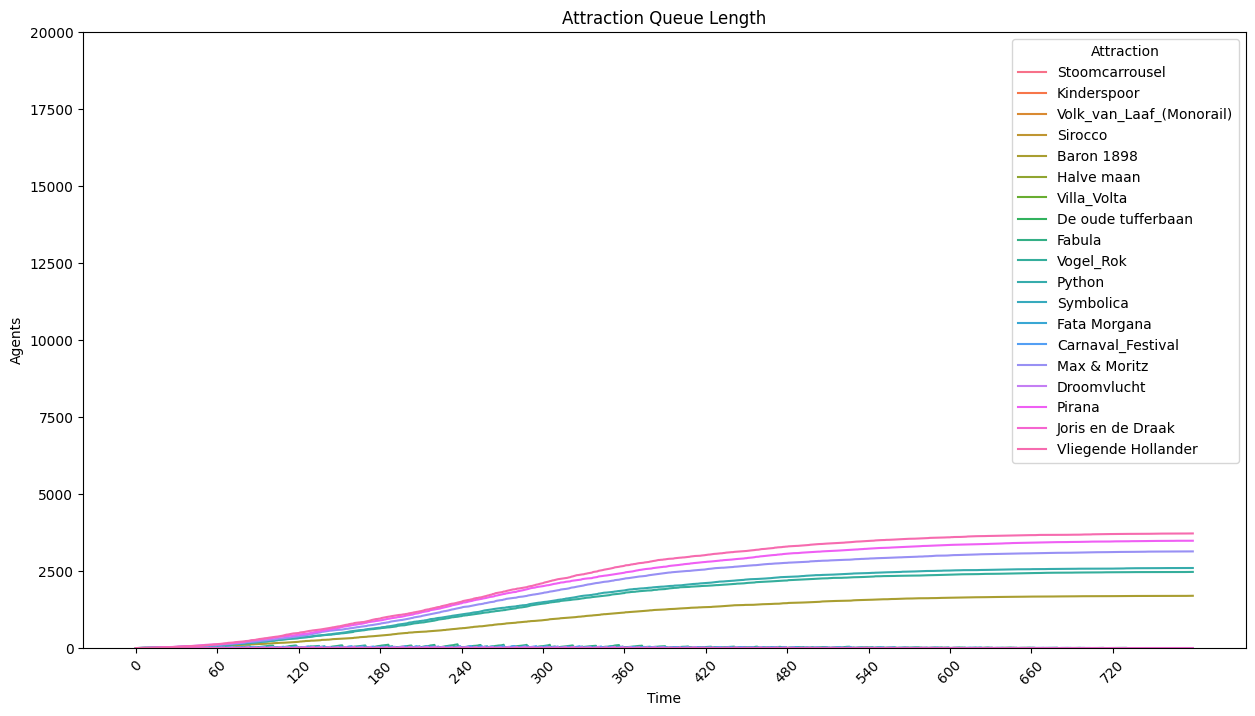

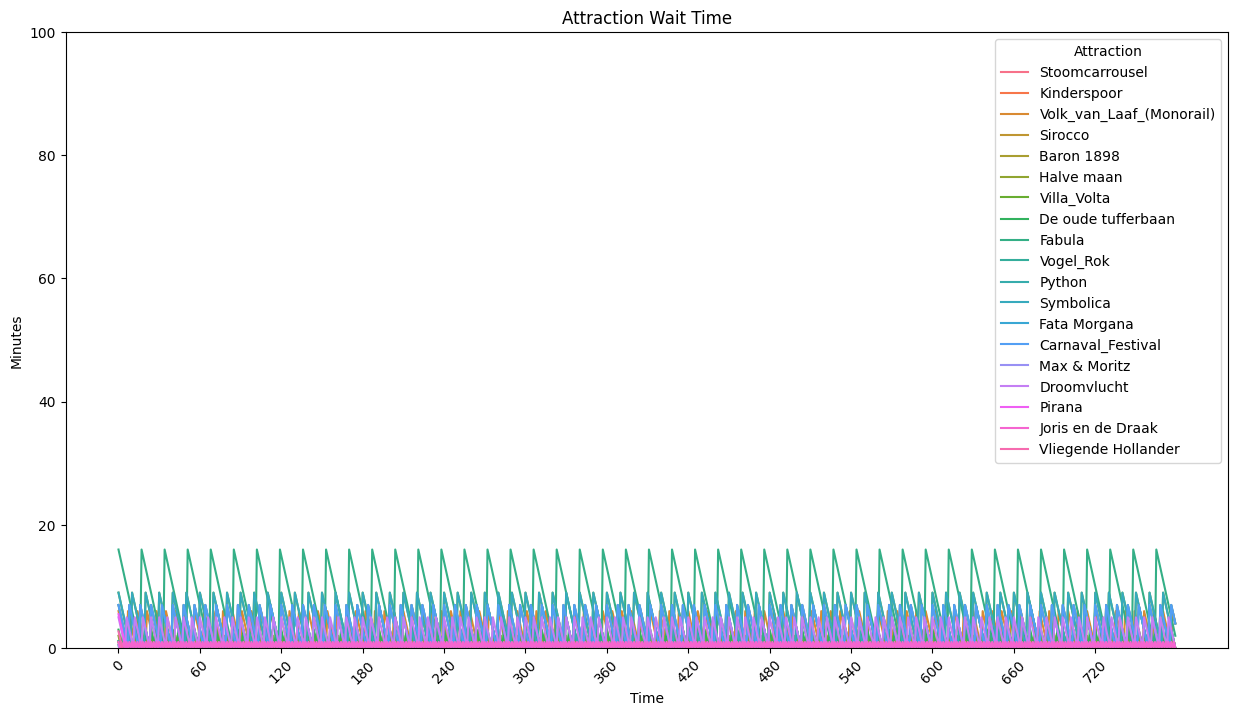

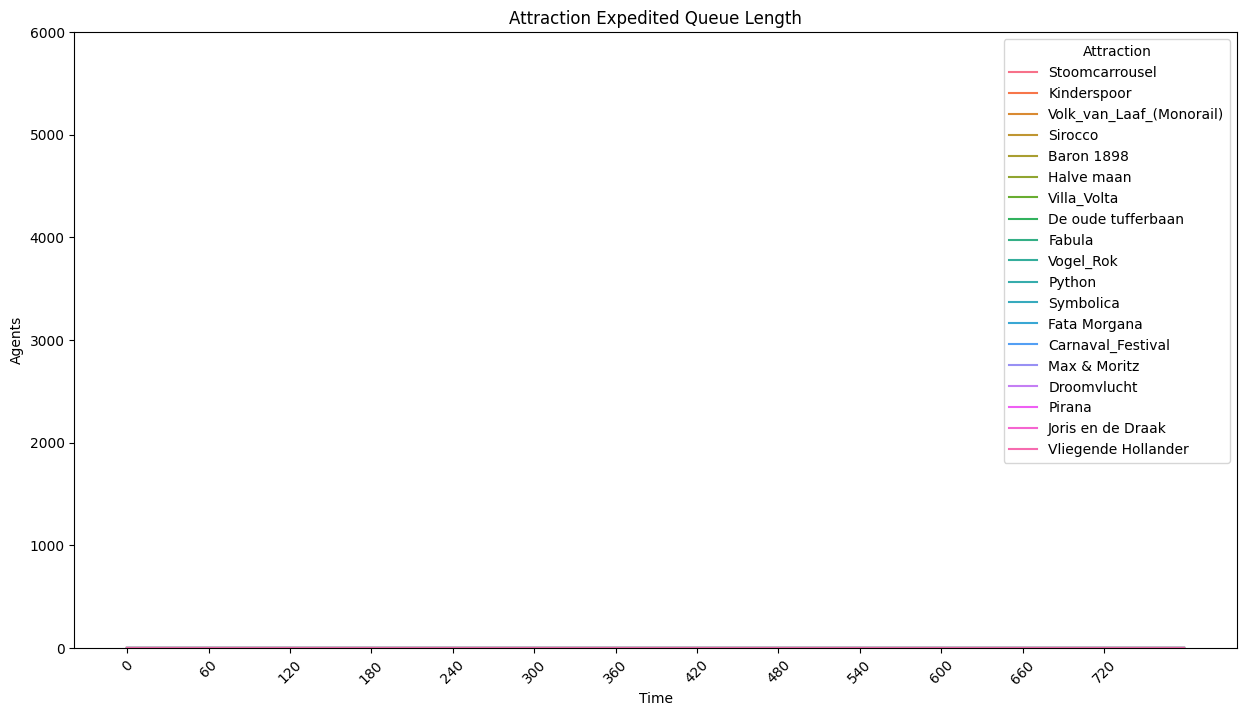

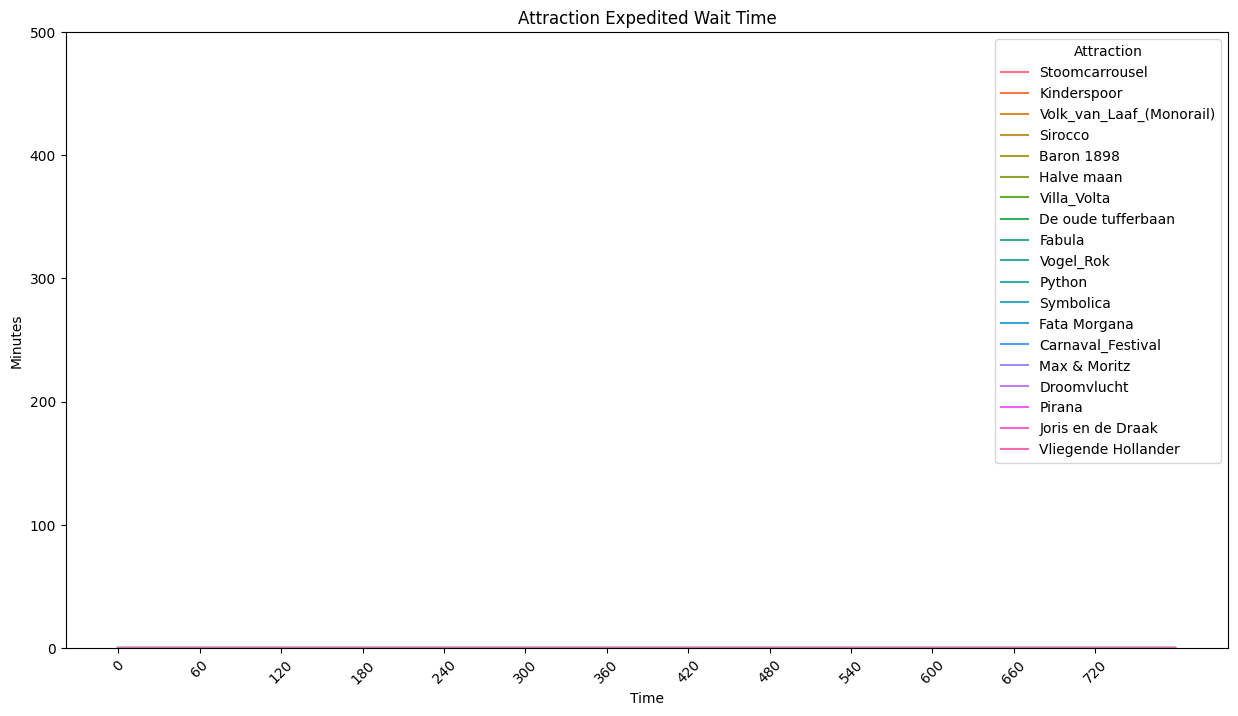

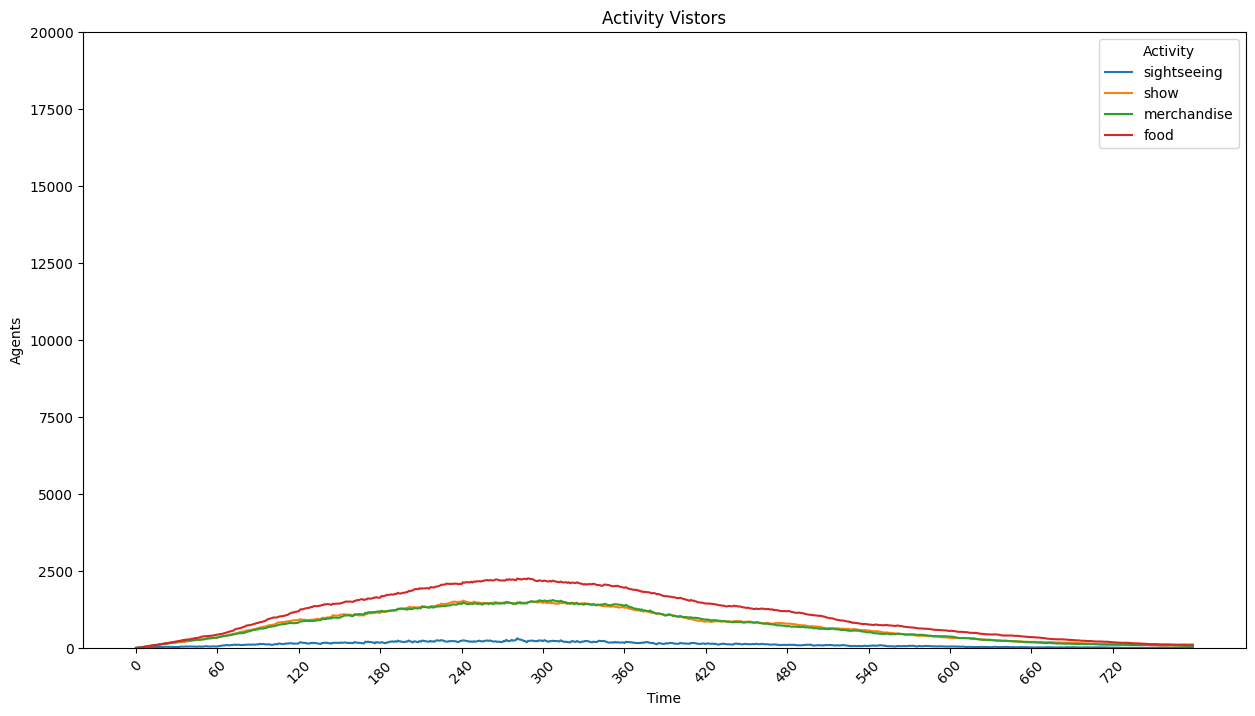

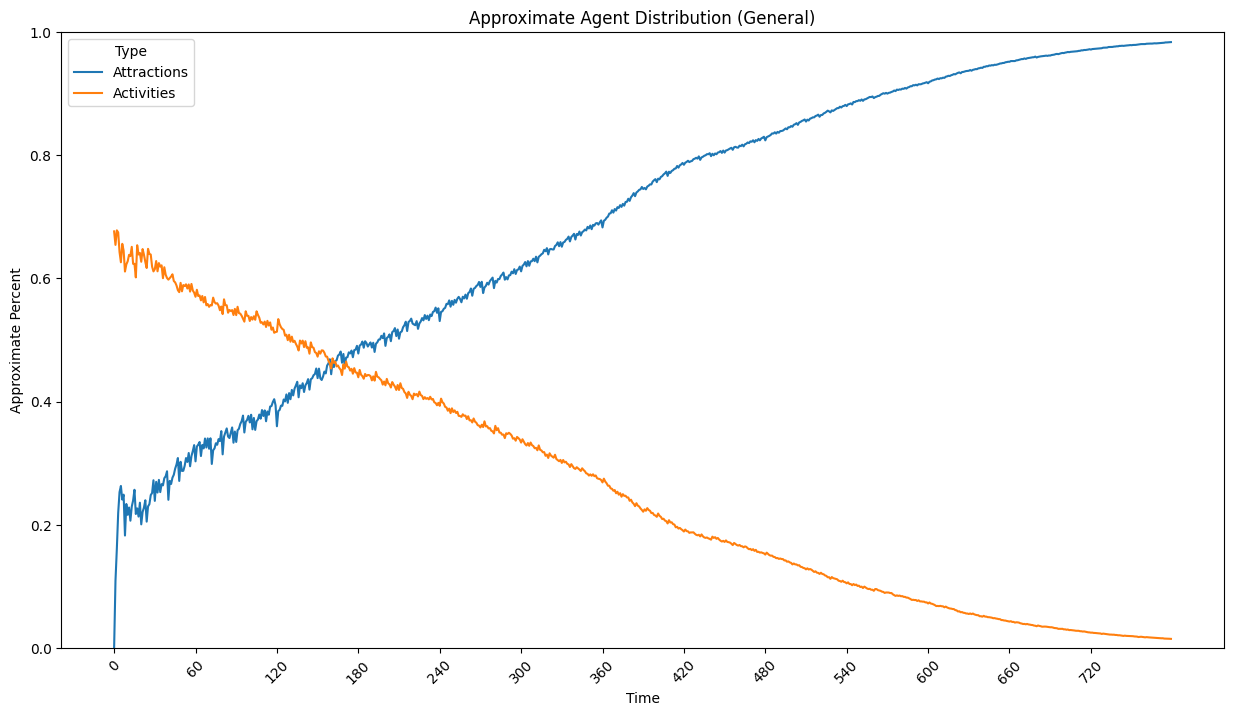

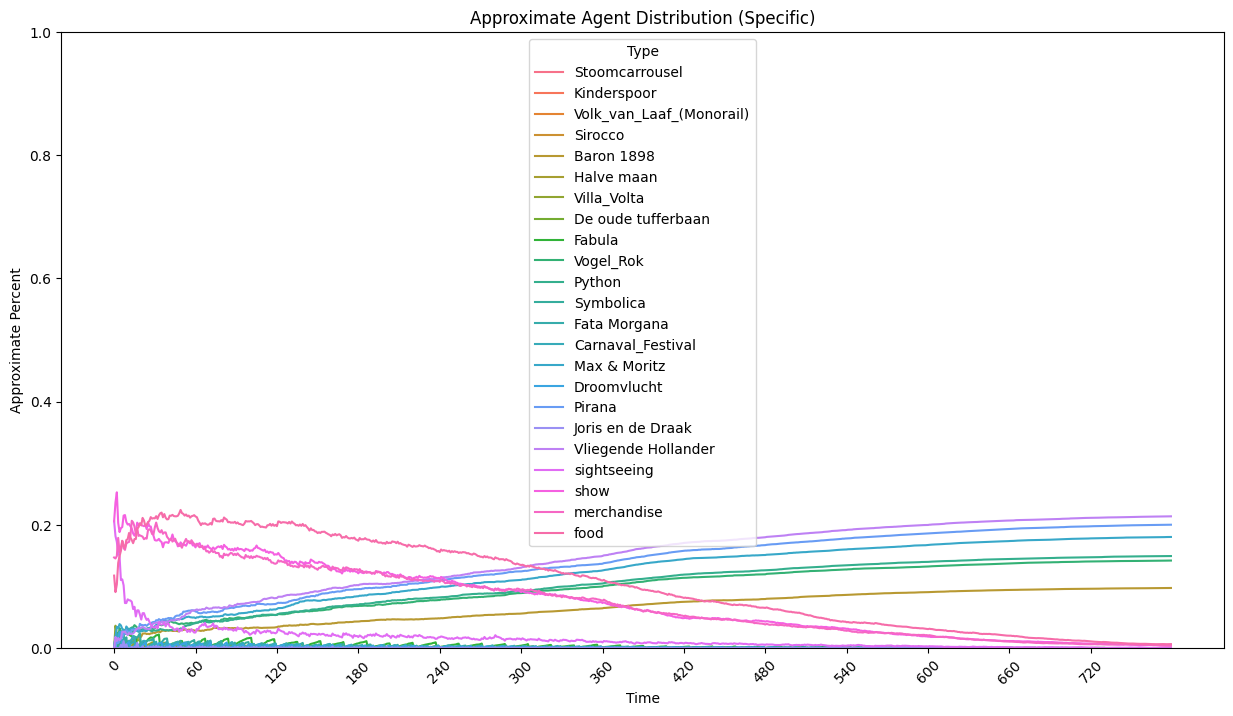

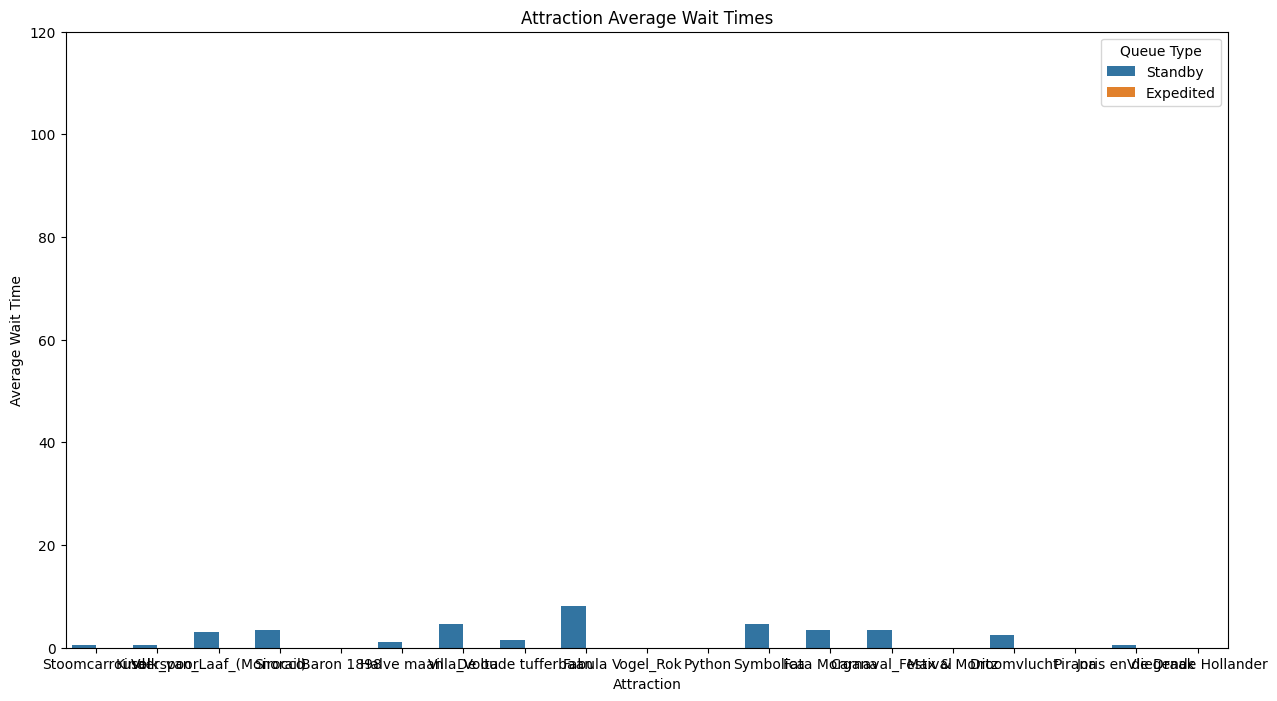

+--------------------------+---------------------+--------------+
| Attraction               |   Average Wait Time | Queue Type   |
|--------------------------+---------------------+--------------|
| Vliegende Hollander      |                0.00 | Expedited    |
| Python                   |                0.00 | Expedited    |
| Vogel_Rok                |                0.00 | Expedited    |
| Carnaval_Festival        |                0.00 | Expedited    |
| Fabula                   |                0.00 | Expedited    |
| De oude tufferbaan       |                0.00 | Expedited    |
| Max & Moritz             |                0.00 | Expedited    |
| Villa_Volta              |                0.00 | Expedited    |
| Fata Morgana             |                0.00 | Expedited    |
| Droomvlucht              |                0.00 | Expedited    |
| Halve maan               |                0.00 | Expedited    |
| Sirocco                  |                0.00 | Expedited    |
| Pirana  

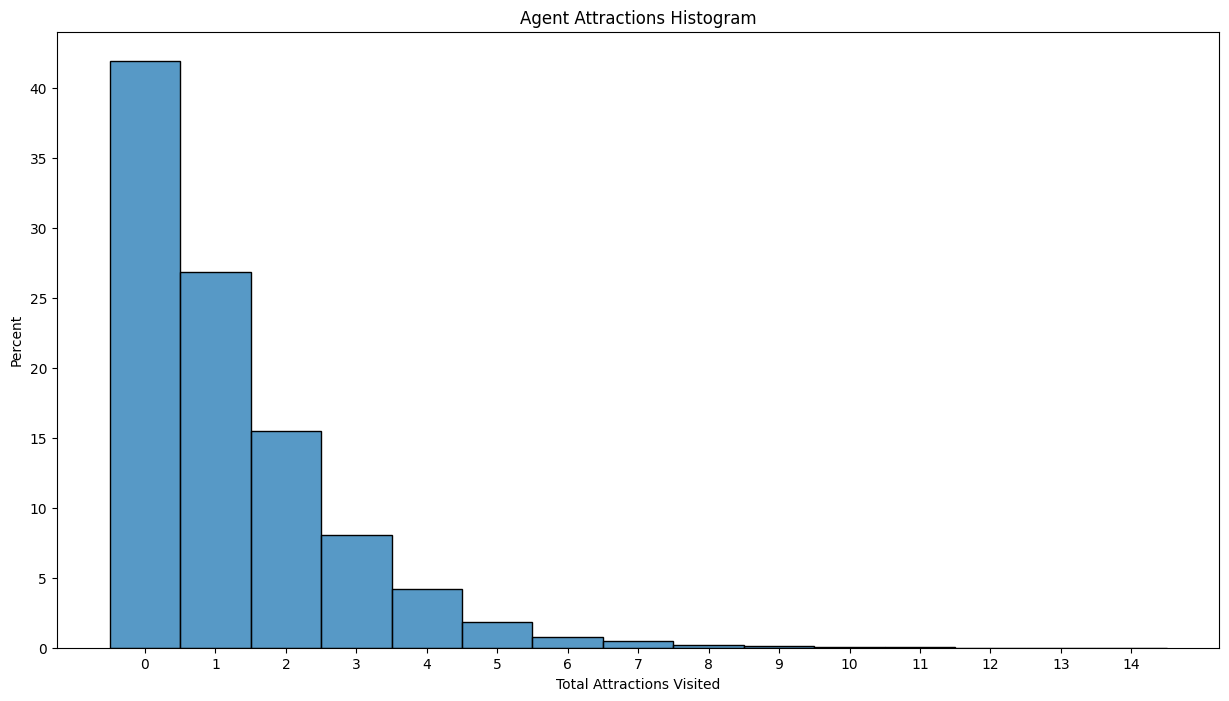

+----------+-----------------------------+
| Metric   |   Total Attractions Visited |
|----------+-----------------------------|
| count    |                    20000.00 |
| mean     |                        1.19 |
| std      |                        1.47 |
| min      |                        0.00 |
| 25%      |                        0.00 |
| 50%      |                        1.00 |
| 75%      |                        2.00 |
| max      |                       14.00 |
+----------+-----------------------------+


F:\School\TUe\Year 1\Quarter3\QuantativeEvaluation\ShapelandEfteling\Code\park.py:336: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, hue=hue, ci=None, estimator=estimator)


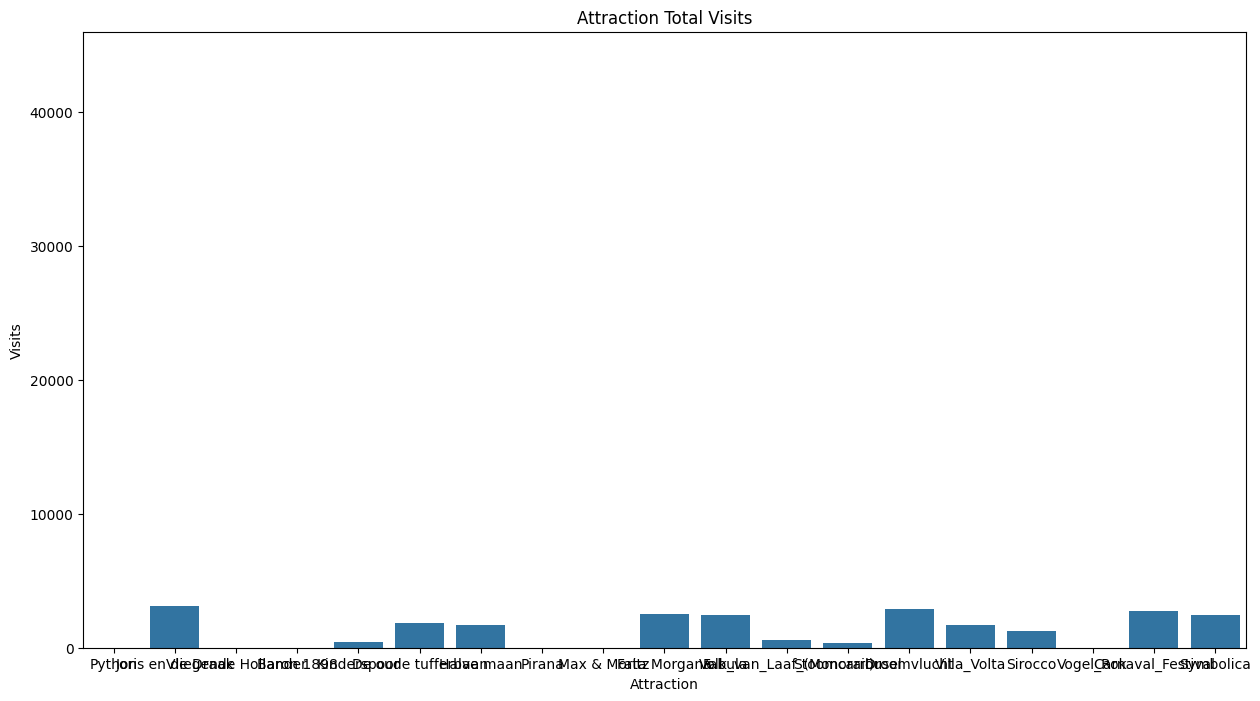

+--------------------------+----------+
| Attraction               |   Visits |
|--------------------------+----------|
| Baron 1898               |        0 |
| Carnaval_Festival        |     2713 |
| De oude tufferbaan       |     1867 |
| Droomvlucht              |     2856 |
| Fabula                   |     2427 |
| Fata Morgana             |     2484 |
| Halve maan               |     1695 |
| Joris en de Draak        |     3135 |
| Kinderspoor              |      427 |
| Max & Moritz             |        0 |
| Pirana                   |        0 |
| Python                   |        0 |
| Sirocco                  |     1245 |
| Stoomcarrousel           |      373 |
| Symbolica                |     2404 |
| Villa_Volta              |     1715 |
| Vliegende Hollander      |        0 |
| Vogel_Rok                |        0 |
| Volk_van_Laaf_(Monorail) |      530 |
+--------------------------+----------+


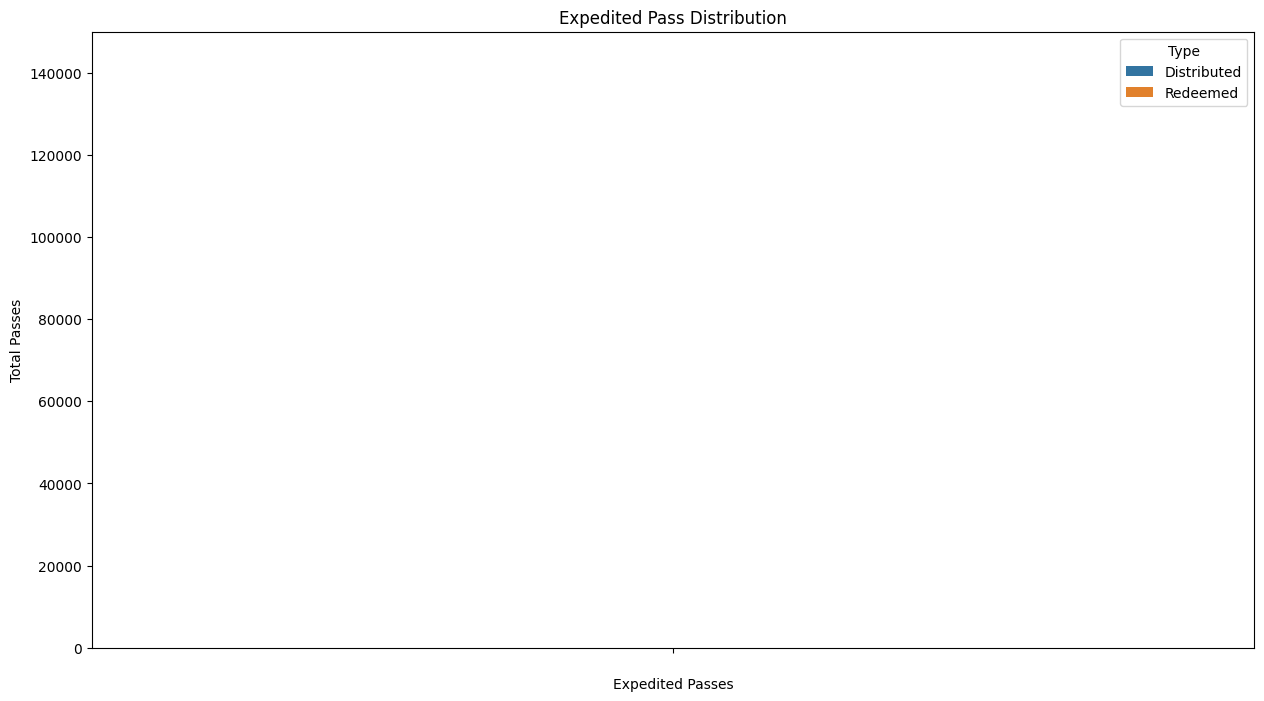

+--------------------+----------------+-------------+
| Expedited Passes   |   Total Passes | Type        |
|--------------------+----------------+-------------|
|                    |              0 | Distributed |
|                    |              0 | Redeemed    |
+--------------------+----------------+-------------+


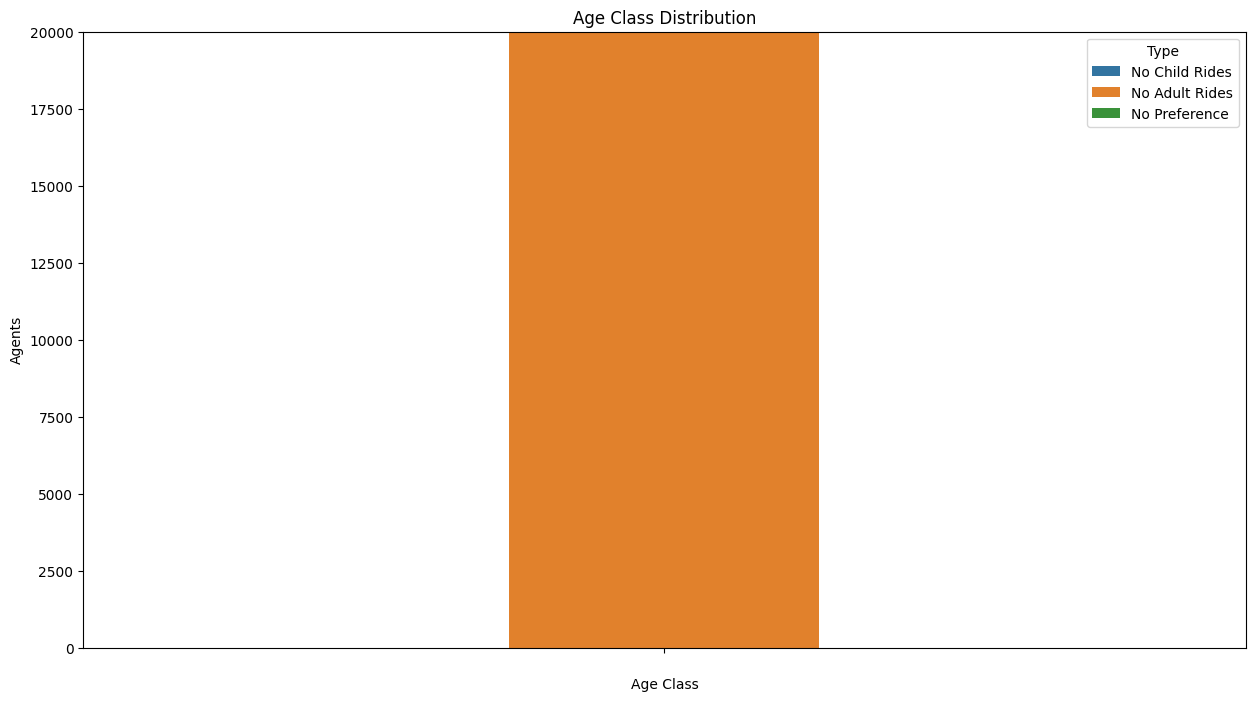

+-------------+----------+----------------+
| Age Class   |   Agents | Type           |
|-------------+----------+----------------|
|             |    20000 | No Adult Rides |
|             |        0 | No Child Rides |
|             |        0 | No Preference  |
+-------------+----------+----------------+
Agent ID: 8370
Agent Archetype: activity_enthusiast
Agent arrived at park at time 161. Agent visited the activity food at time 161. Agent exited the activity food at time 233. Agent visited the activity show at time 234. Agent exited the activity show at time 282. Agent visited the activity show at time 283. Agent exited the activity show at time 331. Agent visited the activity merchandise at time 332. Agent exited the activity merchandise at time 380. Agent entered queue for Vliegende Hollander at time 381. 

Agent ID: 11748
Agent Archetype: park_visitor
Agent arrived at park at time 215. Agent visited the activity show at time 215. Agent exited the activity show at time 239. Agent 

In [46]:
# Initialize Park
RNG_SEED = 5

park = Park(
    attraction_list=ATTRACTIONS,
    activity_list=ACTIVITIES,
    plot_range=PLOT_RANGE,
    random_seed=RNG_SEED,
    version=VERSION,
    verbosity=VERBOSITY
)

# Build Arrivals

park.generate_arrival_schedule(
    arrival_seed=HOURLY_PERCENT, 
    total_daily_agents=TOTAL_DAILY_AGENTS, 
    perfect_arrivals=PERFECT_ARRIVALS,
)

# Build Agents
park.generate_agents(
    behavior_archetype_distribution=AGENT_ARCHETYPE_DISTRIBUTION,
    exp_ability_pct=EXP_ABILITY_PCT,
    exp_wait_threshold=EXP_THRESHOLD,
    exp_limit=EXP_LIMIT
)

# Build Attractions + Activities
park.generate_attractions()
park.generate_activities()

# Pass Time
for _ in range(len(HOURLY_PERCENT.keys()) * 60):
    park.step()

# Save Parameters of Current Run
sim_parameters = {
    "VERSION": VERSION,
    "VERBOSITY": VERBOSITY,
    "SHOW_PLOTS": SHOW_PLOTS,
    "RNG_SEED": RNG_SEED,
    "TOTAL_DAILY_AGENTS": TOTAL_DAILY_AGENTS,
    "PERFECT_ARRIVALS": PERFECT_ARRIVALS,
    "HOURLY_PERCENT": HOURLY_PERCENT,
    "EXP_ABILITY_PCT": EXP_ABILITY_PCT,
    "EXP_THRESHOLD": EXP_THRESHOLD,
    "EXP_LIMIT": EXP_LIMIT,
    "AGENT_ARCHETYPE_DISTRIBUTION": AGENT_ARCHETYPE_DISTRIBUTION,
    "ATTRACTIONS": ATTRACTIONS,
    "ACTIVITIES": ACTIVITIES,
    "BEHAVIOR_ARCHETYPE_PARAMETERS": BEHAVIOR_ARCHETYPE_PARAMETERS,
}
park.write_data_to_file(
    data=sim_parameters, 
    output_file_path=f"{VERSION}/parameters", 
    output_file_format="json"
)

# Store + Print Data
park.make_plots(show=SHOW_PLOTS)
park.print_logs(N = 5)
#park.print_logs(selected_agent_ids = [778])